# SIRD Model

Basic SIRD model for Indonesia Covid 
(data until 20200329) using PSO optimization

![SIRD](../images/Scheme-of-Susceptible-Infectious-Recovered-Death-SIRD-Model-Boxes-represent.png)

In [1]:
PATH_DATA = '../data/raw/'
PATH_DATA_INTERIM = '../data/interim/'
PATH_SRC='../src/'

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [3]:
import pandas as pd
import scipy.integrate as spi
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import pyswarms as ps
import sys

sys.path.insert(1, PATH_SRC)
from covid_model import sird_model, pso_sird

In [4]:
## Assumption
NUMB_OF_POPS=200000000
CURR_DATE='20200329'

## Get The Data

Getting the data and do the summary

In [5]:
col_use=['Sus','Inf','Rec','Dea']
col_use_pred=[x+'_pred' for x in col_use]

In [6]:
## Get The Raw Data
df_daily=pd.read_csv(PATH_DATA+CURR_DATE+'_DailyCase_ID.csv')
df_daily=df_daily.fillna(0)

## Get the compartment value
df_daily['Rec']=df_daily['Sembuh (baru)'].cumsum()
df_daily['Dea']=df_daily['Meninggal (baru)'].cumsum()
df_daily['Inf']=df_daily['Kasus (Kumulatif)']-df_daily['Rec']-df_daily['Dea']
df_daily['Sus']=NUMB_OF_POPS-df_daily['Inf']-df_daily['Rec']-df_daily['Dea']

## Standardized it by divide it by population number
df_daily_sird=df_daily[col_use]/NUMB_OF_POPS
df_daily_sird['weight']=2

In [7]:
df_daily_sird

,Sus,Inf,Rec,Dea,weight
0,1.000000,1.000000e-08,0.000000e+00,0.000000e+00,2
1,1.000000,1.000000e-08,0.000000e+00,0.000000e+00,2
2,1.000000,1.000000e-08,0.000000e+00,0.000000e+00,2
3,1.000000,1.000000e-08,0.000000e+00,0.000000e+00,2
4,1.000000,2.000000e-08,0.000000e+00,0.000000e+00,2
5,1.000000,2.000000e-08,0.000000e+00,0.000000e+00,2
6,1.000000,3.000000e-08,0.000000e+00,0.000000e+00,2
7,1.000000,9.500000e-08,0.000000e+00,0.000000e+00,2
8,1.000000,1.350000e-07,0.000000e+00,0.000000e+00,2
9,1.000000,1.500000e-07,1.000000e-08,1.000000e-08,2


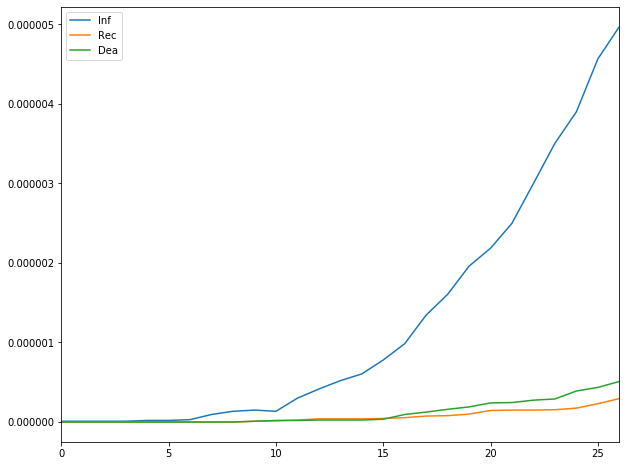

In [8]:
df_daily_sird[['Inf','Rec','Dea']].plot(figsize=(10,8))

## Tuning Parameter SIRD Model

The tuning parameter is more focus on I and R.. meanwhile the newest data is more influence the model than the last one.. (using weight)

In [9]:
# param_b,param_r,param_m

In [10]:
## Summary
## First 23 day --> [0.30421772, 0.01571879, 0.02715623] (1.13785449363775)
## First 25 day --> [0.2942096 , 0.01569591, 0.02679847] (2.7496582873743516)
## All current Data --> [0.282616  , 0.01432964, 0.02584207] (5.365068009)


### Training with first 23st day 

Train the parameter with first 23st day..
compare the result for the next 4 day..

In [11]:
## first 23
df_daily0=df_daily_sird[:23]
prt=int(len(df_daily0)/4)+1
weight_ls=[3.5]*prt+[2]*prt+[1]*prt+[0.5]*prt
weight_ls2=weight_ls[:len(df_daily0)]
weight_ls2.sort()
df_daily0['weight']=weight_ls2

/Users/alamhanz/anaconda/envs/py37_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
df_daily0.tail()

,Sus,Inf,Rec,Dea,weight
18,0.999998,0.000002,8.000000e-08,1.600000e-07,3.5
19,0.999998,0.000002,1.000000e-07,1.900000e-07,3.5
20,0.999997,0.000002,1.450000e-07,2.400000e-07,3.5
21,0.999997,0.000003,1.500000e-07,2.450000e-07,3.5
22,0.999997,0.000003,1.500000e-07,2.750000e-07,3.5


In [13]:
all_param,cost_value=pso_sird(df0=df_daily0,population=NUMB_OF_POPS)

2020-03-29 18:47:33,272 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best:   0%|          |0/20/Users/alamhanz/anaconda/envs/py37_env/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=1.14
2020-03-29 18:47:49,475 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.13785487457048, best pos: [0.30422245 0.01574597 0.02713631]
2020-03-29 18:47:49,487 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=1.26


In [14]:
# all_param,cost_value
# all_param=[0.30421772, 0.01571879, 0.02715623] (1.13785449363775)
all_param,cost_value

(array([0.30421772, 0.01571879, 0.02715623]), 1.1378544936377588)

In [15]:
## Predict
T_start = 0.0
T_inc=1.0
T_end = 23+4
I0=2/NUMB_OF_POPS
S0=1-I0
INPUT = (S0, I0, 0.0, 0.0)
col_use_pred=[x+'_pred' for x in col_use]
T_range = np.arange(T_start, T_end+T_inc, T_inc)
RES = sird_model(all_param,INPUT,T_range)
df_sird_pred=pd.DataFrame(RES,columns=['Sus_pred','Inf_pred','Rec_pred','Dea_pred'])*NUMB_OF_POPS

In [16]:
data_check=pd.concat([df_daily[['Inf','Rec','Dea']],df_sird_pred[['Inf_pred','Rec_pred','Dea_pred']]],axis=1)
error_Inf=np.abs(data_check[23-prt:23]['Inf']-data_check[23-prt:23]['Inf_pred']).mean()
error_Rec=np.abs(data_check[23-prt:23]['Rec']-data_check[23-prt:23]['Rec_pred']).mean()
data_check['Rec_pred_max']=data_check['Rec_pred']+error_Rec
data_check['Rec_pred_min']=data_check['Rec_pred']-error_Rec
data_check['Inf_pred_max']=data_check['Inf_pred']+error_Inf
data_check['Inf_pred_min']=data_check['Inf_pred']-error_Inf
data_check[15:] ## Above 22 is prediction

,Inf,Rec,Dea,Inf_pred,Rec_pred,Dea_pred,Rec_pred_max,Rec_pred_min,Inf_pred_max,Inf_pred_min
15,156.0,9.0,7.0,106.571076,6.289563,10.866031,10.399978,2.179147,171.990722,41.151430
16,197.0,11.0,19.0,139.351063,8.261159,14.272217,12.371574,4.150743,204.770709,73.931417
17,269.0,15.0,25.0,181.275693,10.782772,18.628629,14.893187,6.672356,246.695339,115.856047
18,321.0,16.0,32.0,236.793288,14.121953,24.397496,18.232369,10.011538,302.212934,171.373642
19,392.0,20.0,38.0,308.587151,18.440095,31.857642,22.550510,14.329680,374.006797,243.167505
20,437.0,29.0,48.0,401.234117,24.012478,41.484653,28.122894,19.902063,466.653763,335.814471
21,500.0,30.0,49.0,521.806772,31.264497,54.013452,35.374913,27.154082,587.226418,456.387126
22,600.0,30.0,55.0,679.601354,40.755293,70.410025,44.865709,36.644878,745.021000,614.181708
23,701.0,31.0,58.0,884.001747,53.049282,91.649476,57.159697,48.938866,949.421393,818.582101
24,780.0,35.0,78.0,1149.915700,69.043127,119.280907,73.153543,64.932712,1215.335346,1084.496054


In [17]:
np.abs(data_check[23:27]['Inf']-data_check[23:27]['Inf_pred']).mean()

521.2782791689833

In [18]:
np.abs(data_check[23:27]['Rec']-data_check[23:27]['Rec_pred']).mean()

39.426968780714375

### Training with first 25st day 

Train the parameter with first 25st day..
compare the result for the next 2 day..

In [19]:
## first 25
df_daily0=df_daily_sird[:25]
prt=int(len(df_daily0)/4)+1
weight_ls=[3.5]*prt+[2]*prt+[1]*prt+[0.5]*prt
weight_ls2=weight_ls[:len(df_daily0)]
weight_ls2.sort()
df_daily0['weight']=weight_ls2

/Users/alamhanz/anaconda/envs/py37_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [20]:
df_daily0.tail()

,Sus,Inf,Rec,Dea,weight
20,0.999997,0.000002,1.450000e-07,2.400000e-07,3.5
21,0.999997,0.000003,1.500000e-07,2.450000e-07,3.5
22,0.999997,0.000003,1.500000e-07,2.750000e-07,3.5
23,0.999996,0.000004,1.550000e-07,2.900000e-07,3.5
24,0.999996,0.000004,1.750000e-07,3.900000e-07,3.5


In [21]:
all_param,cost_value=pso_sird(df0=df_daily0,population=NUMB_OF_POPS)

2020-03-29 18:49:22,468 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=6.64
2020-03-29 18:49:39,465 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.641908087978618, best pos: [0.39529562 0.06460647 0.08685332]
2020-03-29 18:49:39,477 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=2.75
2020-03-29 18:49:57,233 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.7496582873743516, best pos: [0.2920497  0.01284591 0.0274068 ]
2020-03-29 18:49:57,246 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=3.65
2020-03-29 18:50:13,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost

In [22]:
# all_param,cost_value
# all_param=[0.2942096 , 0.01569591, 0.02679847] (2.7496582873743516)
all_param,cost_value

(array([0.2942096 , 0.01569591, 0.02679847]), 2.7496582873743516)

In [23]:
## Predict
T_start = 0.0
T_inc=1.0
# T_end = 23+4
T_end = 30*6

I0=2/NUMB_OF_POPS
S0=1-I0
INPUT = (S0, I0, 0.0, 0.0)
col_use_pred=[x+'_pred' for x in col_use]
T_range = np.arange(T_start, T_end+T_inc, T_inc)
RES = sird_model(all_param,INPUT,T_range)
df_sird_pred=pd.DataFrame(RES,columns=['Sus_pred','Inf_pred','Rec_pred','Dea_pred'])*NUMB_OF_POPS

In [24]:
data_check=pd.concat([df_daily[['Inf','Rec','Dea']],df_sird_pred[['Inf_pred','Rec_pred','Dea_pred']]],axis=1)
error_Inf=np.abs(data_check[23-prt:23]['Inf']-data_check[23-prt:23]['Inf_pred']).mean()
error_Rec=np.abs(data_check[23-prt:23]['Rec']-data_check[23-prt:23]['Rec_pred']).mean()
data_check['Inf_pred_max']=data_check['Inf_pred']+error_Inf
data_check['Inf_pred_min']=data_check['Inf_pred']-error_Inf
data_check['Rec_pred_max']=data_check['Rec_pred']+error_Rec
data_check['Rec_pred_min']=data_check['Rec_pred']-error_Rec
data_check[20:29] ## Above 24 is prediction

,Inf,Rec,Dea,Inf_pred,Rec_pred,Dea_pred,Inf_pred_max,Inf_pred_min,Rec_pred_max,Rec_pred_min
20,437.0,29.0,48.0,330.234858,20.467387,34.945062,427.881257,232.588459,25.227338,15.707436
21,500.0,30.0,49.0,425.776257,26.424968,45.116758,523.422657,328.129858,31.184918,21.665017
22,600.0,30.0,55.0,548.728337,34.091775,58.206707,646.374736,451.081938,38.851726,29.331824
23,701.0,31.0,58.0,707.033154,43.963049,75.060460,804.679553,609.386754,48.723000,39.203098
24,780.0,35.0,78.0,910.980322,56.680419,96.773505,1008.626721,813.333923,61.440370,51.920468
25,913.0,46.0,87.0,1173.933682,73.077218,124.768636,1271.580081,1076.287282,77.837169,68.317267
26,994.0,59.0,102.0,1511.579435,94.131601,160.715907,1609.225834,1413.933036,98.891552,89.371650
27,NaN,NaN,NaN,1946.482269,121.250660,207.017725,2044.128669,1848.835870,126.010611,116.490709
28,NaN,NaN,NaN,2506.435961,156.167586,266.633256,2604.082360,2408.789561,160.927537,151.407635


In [27]:
np.abs(data_check[24:27]['Inf']-data_check[24:27]['Inf_pred']).mean()

303.16447956568976

In [28]:
np.abs(data_check[24:27]['Rec']-data_check[24:27]['Rec_pred']).mean()

27.96307939155848

### Training All Data

In [32]:
## all current data
df_daily0=df_daily_sird.copy()
prt=int(len(df_daily0)/4)+1
weight_ls=[3.5]*prt+[2]*prt+[1]*prt+[0.5]*prt
weight_ls2=weight_ls[:len(df_daily0)]
weight_ls2.sort()
df_daily0['weight']=weight_ls2

In [33]:
df_daily0.tail()

,Sus,Inf,Rec,Dea,weight
22,0.999997,0.000003,1.500000e-07,2.750000e-07,3.5
23,0.999996,0.000004,1.550000e-07,2.900000e-07,3.5
24,0.999996,0.000004,1.750000e-07,3.900000e-07,3.5
25,0.999995,0.000005,2.300000e-07,4.350000e-07,3.5
26,0.999994,0.000005,2.950000e-07,5.100000e-07,3.5


In [34]:
all_param,cost_value=pso_sird(df0=df_daily0,population=NUMB_OF_POPS)

2020-03-29 18:52:33,710 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=5.37
2020-03-29 18:52:49,001 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.3658046197936144, best pos: [0.28150296 0.01440298 0.02458701]
2020-03-29 18:52:49,015 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=6.58
2020-03-29 18:53:04,294 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.584590887204723, best pos: [0.32180991 0.03076024 0.05112885]
2020-03-29 18:53:04,306 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.15, 'c2': 0.95, 'w': 0.25}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=5.68
2020-03-29 18:53:19,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost

In [35]:
all_param,cost_value

(array([0.282616  , 0.01432964, 0.02584207]), 5.365068009459222)

In [36]:
## Predict
T_start = 0.0
T_inc=1.0
# T_end = 23+4
T_end = 30*6

I0=2/NUMB_OF_POPS
S0=1-I0
INPUT = (S0, I0, 0.0, 0.0)
col_use_pred=[x+'_pred' for x in col_use]
T_range = np.arange(T_start, T_end+T_inc, T_inc)
RES = sird_model(all_param,INPUT,T_range)
df_sird_pred=pd.DataFrame(RES,columns=['Sus_pred','Inf_pred','Rec_pred','Dea_pred'])*NUMB_OF_POPS

In [37]:
data_check=pd.concat([df_daily[['Inf','Rec','Dea']],df_sird_pred[['Inf_pred','Rec_pred','Dea_pred']]],axis=1)
error_Inf=np.abs(data_check[23-prt:23]['Inf']-data_check[23-prt:23]['Inf_pred']).mean()
error_Rec=np.abs(data_check[23-prt:23]['Rec']-data_check[23-prt:23]['Rec_pred']).mean()
data_check['Inf_pred_max']=data_check['Inf_pred']+error_Inf
data_check['Inf_pred_min']=data_check['Inf_pred']-error_Inf
data_check['Rec_pred_max']=data_check['Rec_pred']+error_Rec
data_check['Rec_pred_min']=data_check['Rec_pred']-error_Rec
data_check[20:29] ## Above 24 is prediction

,Inf,Rec,Dea,Inf_pred,Rec_pred,Dea_pred,Inf_pred_max,Inf_pred_min,Rec_pred_max,Rec_pred_min
20,437.0,29.0,48.0,274.360567,16.097855,29.030872,421.572703,127.148430,23.555740,8.639969
21,500.0,30.0,49.0,349.742239,20.553289,37.065802,496.954375,202.530103,28.011175,13.095403
22,600.0,30.0,55.0,446.390396,26.265682,47.367533,593.602532,299.178260,33.723568,18.807797
23,701.0,31.0,58.0,570.614783,33.607976,60.608626,717.826919,423.402647,41.065862,26.150091
24,780.0,35.0,78.0,728.044829,42.912902,77.389129,875.256965,580.832693,50.370788,35.455016
25,913.0,46.0,87.0,929.107190,54.796737,98.820437,1076.319326,781.895053,62.254622,47.338851
26,994.0,59.0,102.0,1186.404970,70.004403,126.245944,1333.617107,1039.192834,77.462289,62.546518
27,NaN,NaN,NaN,1513.492973,89.337080,161.110494,1660.705109,1366.280836,96.794966,81.879194
28,NaN,NaN,NaN,1930.922048,114.009469,205.604680,2078.134184,1783.709911,121.467354,106.551583


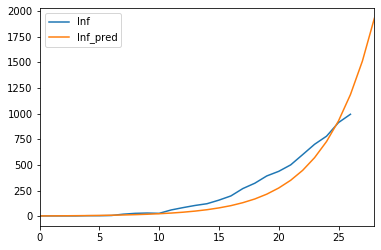

In [42]:
check_col='Inf'
data_check[:29][[check_col,check_col+'_pred']].plot()

In [43]:
# df_sird_pred['Dea_pred'].max()

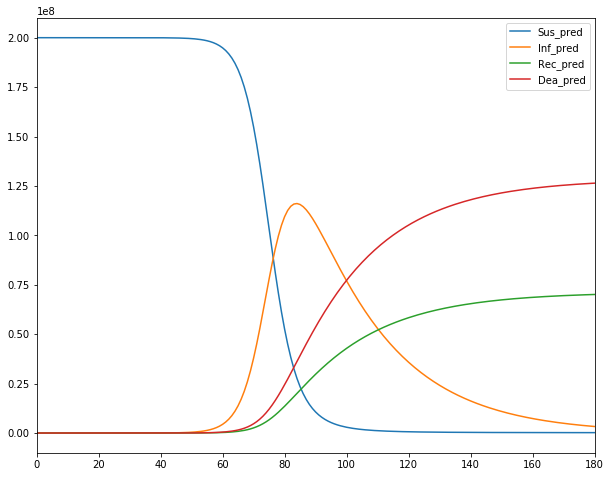

In [44]:
# df_sird_pred[['Inf_pred','Rec_pred','Dea_pred']].plot(figsize=(10,8))
df_sird_pred.plot(figsize=(10,8))

## Conclusion

Distancing mulai terlihat efeknya.. namun, hal ini tidak dibarengi dengan Recover Daily ratenya.. Pemerintah harus bisa recover lebih cepat.. 

Prediction :Hari ini ada 200 kasus baru,, semoga selasa tidak sampai 230 kasus baru T__T

## Reference
    
    Data : https://kawalcovid19.blob.core.windows.net/viz/statistik_harian.html
    
    Source Script : http://epirecip.es/epicookbook/chapters/kr08/2_1/python_original
    
    Image 1 : https://www.researchgate.net/figure/Scheme-of-Susceptible-Infectious-Recovered-Death-SIRD-Model-Boxes-represent_fig1_41507287
    
    Image 2 : https://www.chegg.com/homework-help/questions-and-answers/codes-problem-code-1-function-siddeterm-simulation-deterministic-sird-model-using-differen-q21316613